In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from joblib import Parallel, delayed
from scipy.spatial.distance import cdist
from geopy.distance import distance as geodist
from scipy.spatial import distance
from tqdm import tqdm
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle
import prod_infra as infra
import pandas as pd
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
import auxiliary as auxiliary
import random
from kneed import KneeLocator
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
import importlib
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#importlib.reload(auxiliary)

<module 'auxiliary' from '/mnt/s3/pagaya-pro-bucket/projects/re_recommendation_system/auxiliary.py'>

In [3]:
def calculate_wcss(X, points, price, k):
    clusters_dict = Counter(points)
    print(clusters_dict)
    clusters_dict = {k: v / len(points) for k, v in clusters_dict.items()}
    
    wcss = 0
    for cent in range(k):
        wcss += np.sum(np.square(price[(pd.Series(points)==cent).values] - np.mean(price[(pd.Series(points)==cent).values]))) * clusters_dict[cent]
    return wcss

def find_best_k(X):
    k_max = 40 #int(np.sqrt(X.shape[0]))
    k_min = 5
    jump = 5
    K_option = range(k_min, k_max, jump)
    wcss = np.zeros((k_max-k_min)/jump)
    for k in K_option:
        clusterer = KMeansClusterer(k, cosine_distance)
        clusters = clusterer.cluster(X.drop(['price'], axis=1).values, True, trace=True)
        wcss[k-2] = calculate_wcss(X.drop(['price'], axis=1) , clusters, X.price,10)
    kn = KneeLocator(np.array(K_option), wcss, curve='convex', direction='decreasing') #detect elbows
    best_k = kn.knee
    return best_k

def manhattan_distances(A, B):
    return np.sum(np.abs(A - B))

def evaluate_distance_function(df, distance_func):
    best_k = 10
    rng = random.Random()
    rng.seed(123)
    clusterer = KMeansClusterer(best_k, distance_func, avoid_empty_clusters=True, rng=rng)
    clusters = clusterer.cluster(df.drop(['price'], axis=1).values, True, trace=False)
    wcss = calculate_wcss(df.drop(['price'], axis=1) , clusters, df.price, best_k)
    return wcss

def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[1])
    ax.set_ylabel(labels[2])
    ax.set_zlabel(labels[0])
    ax.scatter(chart_data.iloc[:,1], chart_data.iloc[:,2], chart_data.iloc[:,0], c=y_pred)
    ax.set_zlim(-4, 4)
    
def make_random_kmenas(k_means_data,):
    k_means_shuffle = shuffle(k_means_data)
    splits = np.array_split(k_means_data, 15)
    rand_wcss=0
    for i in splits:
        rand_wcss += (np.sum(np.square(target_houston.loc[i.index].price - np.mean(target_houston.loc[i.index].price))) * i.shape[0])/k_means_shuffle.shape[0]
    print("wcss for random cluster: ",rand_wcss)
    return rand_wcss

def make_chart_tsne(chart_data, y_pred, labels):
    plt.style.use("Solarize_Light2")
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[1])
    ax.set_ylabel(labels[2])
    ax.set_zlabel(labels[0])
    ax.scatter(chart_data.iloc[:,1], chart_data.iloc[:,2], chart_data.iloc[:,0], c=y_pred)
    

class KmeansEstimator(BaseEstimator,ClassifierMixin):
    def __init__(self, k, distance='euclidean', 
                 bedrooms = 1, 
                 gla_sqft = 1,
                 year_built = 1,
                 full_baths = 1,
                 has_fireplace = 1,
                 has_spa = 1,
                 bath_to_room = 1,
                 sqft_to_room = 1, 
                 month=1,
                new_construction_flag_=1,
                new_construction_flag_n=1,
                new_construction_flag_y=1,
                weighted=True):
        self.k = k
        # TODO distance_func
        self.distance = distance
        self.bedrooms = bedrooms
        self.month = month
        self.gla_sqft = gla_sqft
        self.year_built = year_built
        self.full_baths = full_baths
        self.has_fireplace = has_fireplace
        self.has_spa = has_spa
        self.sqft_to_room = sqft_to_room
        self.bath_to_room = bath_to_room
        self.new_construction_flag_ = new_construction_flag_
        self.new_construction_flag_n = new_construction_flag_n
        self.new_construction_flag_y = new_construction_flag_y
        self.weighted = weighted
        

    def weighted_features(self, X):
        X_copy = X.copy()
        X_copy['bedrooms'] *= self.bedrooms
        X_copy['gla_sqft'] *= self.gla_sqft
        X_copy['year_built'] *= self.year_built
        X_copy['full_baths'] *= self.full_baths
        X_copy['has_fireplace'] *= self.has_fireplace
        X_copy['has_spa'] *= self.has_spa
        X_copy['bath_to_room'] *= self.bath_to_room
        X_copy['sqft_to_room'] *= self.sqft_to_room
        X_copy['month'] *= self.month
        X_copy['new_construction_flag_y'] *= self.new_construction_flag_y
        X_copy['new_construction_flag_n'] *= self.new_construction_flag_n
        X_copy['new_construction_flag_'] *= self.new_construction_flag_
        return X_copy
        
    def fit(self, X, y):
        rng = random.Random()
        rng.seed(123) 
        if self.weighted:
            X = self.weighted_features(X)
        self.clusterer = KMeansClusterer(self.k, self.distance, avoid_empty_clusters=True, rng=rng)
        clusters = self.clusterer.cluster(X.values, True, trace=False)
        self.clusters = clusters
        return self

    def predict(self, X):
        return self.clusters
        #X = self.weighted_features(X) - TODO remove if train!=test
        #clusters = X.apply(self.clusterer.classify, axis=1)
        #clusters = self.clusterer.classify(X.values) 
        return clusters
    
    
    def calculate_wcss(self, X, points, price, k):
        clusters_dict = Counter(points)
        clusters_dict = {k: v / len(points) for k, v in clusters_dict.items()}
        wcss = 0
        for cent in range(k):
            wcss += np.sum(np.square(price[(pd.Series(points)==cent).values] - np.mean(price[(pd.Series(points)==cent).values]))) * clusters_dict[cent]
        return wcss
    
    def score(self, X, y):
        clusters = self.predict(X)
        wcss = self.calculate_wcss(X, clusters, y, self.k)
        return wcss
    

In [18]:
# load data and prepare to kmeans 
data = auxiliary.load_data()
data_sfr_pre, target = auxiliary.preprocess_data(data)
k_means_data, target_houston = auxiliary.preprocess_data_kmeans(data_sfr_pre, target)

In [20]:
# run KmeansEstimator
clf = KmeansEstimator(15, cosine_distance, weighted=False)
clf.fit(k_means_data, target_houston.price)
wcss_score = clf.score(k_means_data, target_houston.price)
print('wcss score :',  wcss_score)

wcss score : 102638232342456.64


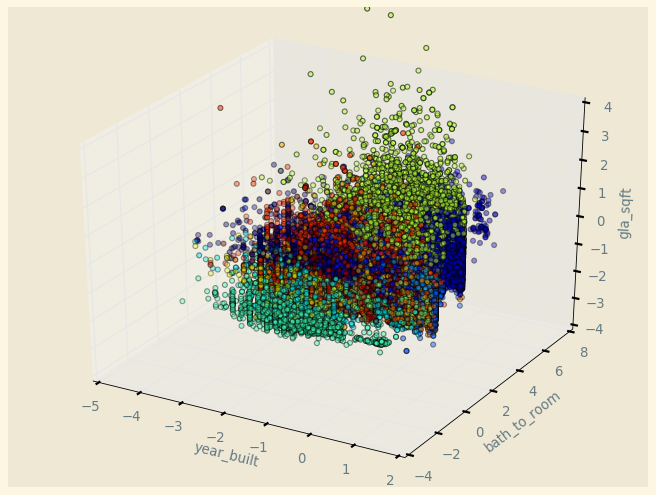

In [43]:
# plot 3d according to the chosen features
important_features = ['gla_sqft','year_built', 'bath_to_room']
make_chart(k_means_data[important_features], list(clf.predict(k_means_data)), important_features)

# Random split

In [26]:
rand_wcss_score = make_random_kmenas(k_means_data)
print('rand wcss score is better :',  rand_wcss_score<wcss_score)

wcss for random cluster:  137397647142290.64
rand wcss score is better : False


# TSNE

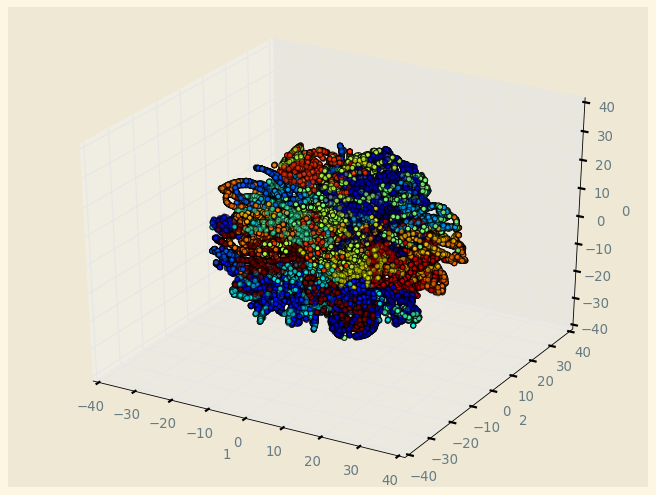

In [42]:
X_embedded = TSNE(n_components=3, init='random').fit_transform(k_means_data.values)
make_chart_tsne(pd.DataFrame(X_embedded), list(clf.predict(k_means_data)), labels=['0','1','2'])

# Grid Search

In [ ]:
%%time
parameters = {'distance': [cosine_distance],
              'k': [15],
                'bedrooms':np.arange(0.8,1.3,0.2),
                 'gla_sqft':np.arange(0.8,1.3,0.2),
                 'year_built':np.arange(0.8,1.3,0.2),
                 'full_baths':np.arange(0.8,1.3,0.2),
                 'has_fireplace':np.arange(0.8,1.3,0.2),
                 'has_spa':np.arange(0.8,1.3,0.2),
                 'bath_to_room': np.arange(0.8,1.3,0.2),
                 'sqft_to_room':np.arange(0.8,1.3,0.2)}
cv=[(slice(None), slice(None))]
clf = GridSearchCV(KmeansEstimator(15, cosine_distance), parameters, n_jobs=32,verbose=10, cv=cv)
print(clf.best_params_)
print(clf.best_score_)

Fitting 1 folds for each of 6561 candidates, totalling 6561 fits
